In [166]:
import pandas as pd
import numpy as np
from datetime import timedelta, date, datetime
import calendar
import matplotlib.pyplot as plt
import yfinance as yf
from functions import functions
import scipy
from IPython.display import display, HTML
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from fredapi import Fred
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

%reload_ext autoreload
%autoreload 2
%matplotlib inline

spy = yf.download("SPY", start = "2000-01-01", end = datetime.today().strftime("%Y-%m-%d"))
fred_api = '3040e25eb696826211b7ea235504a8ae'
fred = Fred(api_key=fred_api)

[*********************100%%**********************]  1 of 1 completed


#### Trend Following

In [2]:
trend_following_sig = spy.loc[:'2010-12-31'].copy()
trend_following_sig

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,148.250000,148.250000,143.875000,145.437500,94.262566,8164300
2000-01-04,143.531250,144.062500,139.640625,139.750000,90.576324,8089800
2000-01-05,139.937500,141.531250,137.250000,140.000000,90.738365,12177900
2000-01-06,139.625000,141.500000,137.750000,137.750000,89.280045,6227200
2000-01-07,140.312500,145.750000,140.062500,145.750000,94.465111,8066500
...,...,...,...,...,...,...
2010-12-27,125.129997,125.769997,125.040001,125.650002,98.897476,58126000
2010-12-28,125.900002,125.949997,125.500000,125.830002,99.039154,55309100
2010-12-29,125.980003,126.199997,125.900002,125.919998,99.109985,58033100


Text(0.5, 0.98, 'Trend Following (50DMA)')

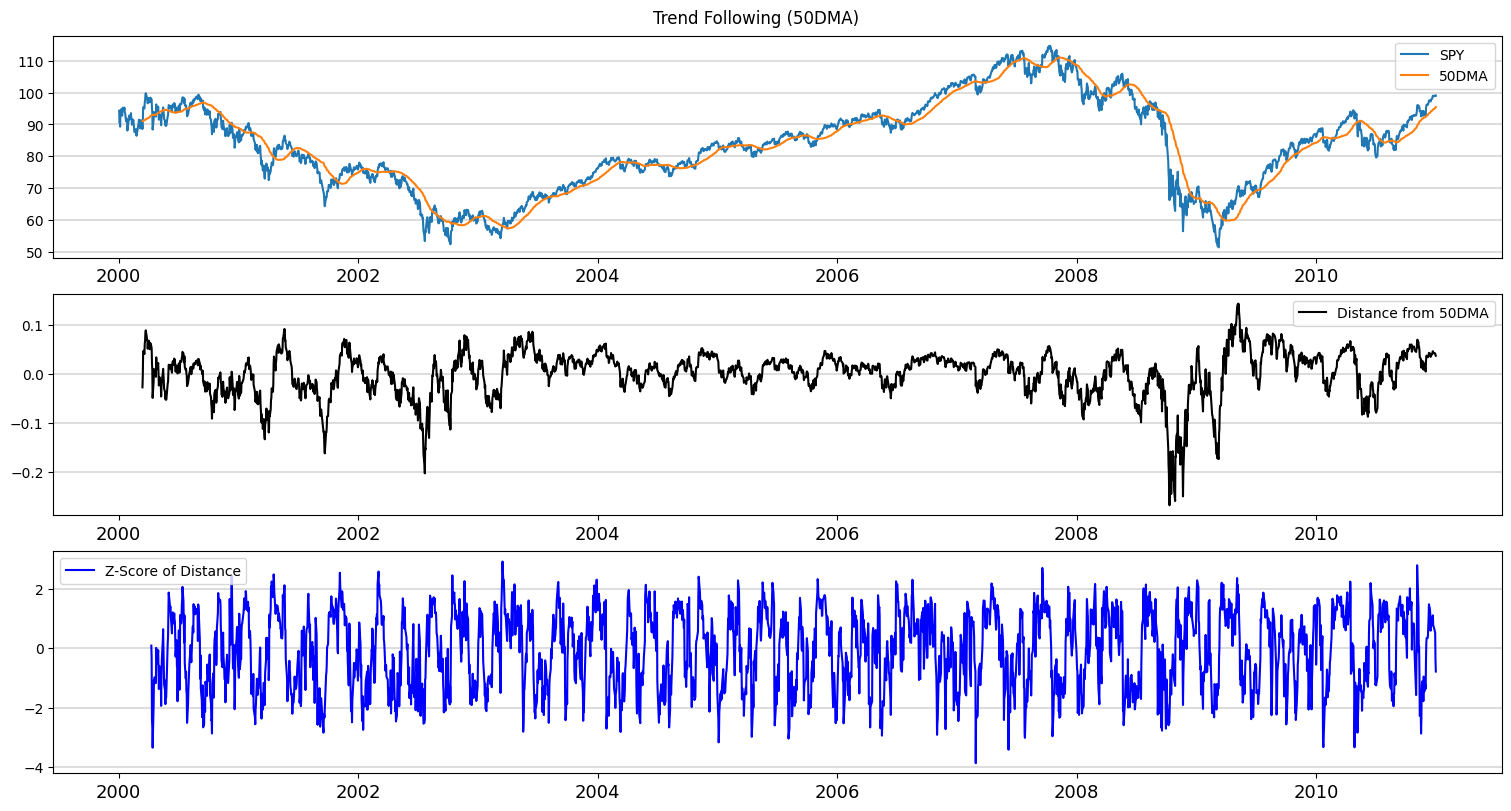

In [3]:
trend_following_sig["50DMA"] = trend_following_sig[["Adj Close"]].rolling(50).mean()
trend_following_sig["dist_50dma"] = (trend_following_sig["Adj Close"] / trend_following_sig["50DMA"])  - 1
z_50dma_dist_obj = trend_following_sig["dist_50dma"].rolling(20)
z_50dma_dist_z = (trend_following_sig["dist_50dma"] - z_50dma_dist_obj.mean()) / z_50dma_dist_obj.std()

fig, ax = plt.subplots(3, 1, figsize = (15, 8), constrained_layout = True, sharex = True)

ax[0].plot(trend_following_sig["Adj Close"], label = "SPY")
ax[0].plot(trend_following_sig["50DMA"], label = "50DMA")
ax[0].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[0].legend()
ax[0].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[1].plot(trend_following_sig["dist_50dma"], label = "Distance from 50DMA", color = "black")
ax[1].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[1].legend()
ax[1].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[2].plot(z_50dma_dist_z, label = "Z-Score of Distance", color = "blue")
ax[2].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[2].legend()
ax[2].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
fig.suptitle("Trend Following (50DMA)")

Text(0.5, 0.98, 'Trend Following (200DMA)')

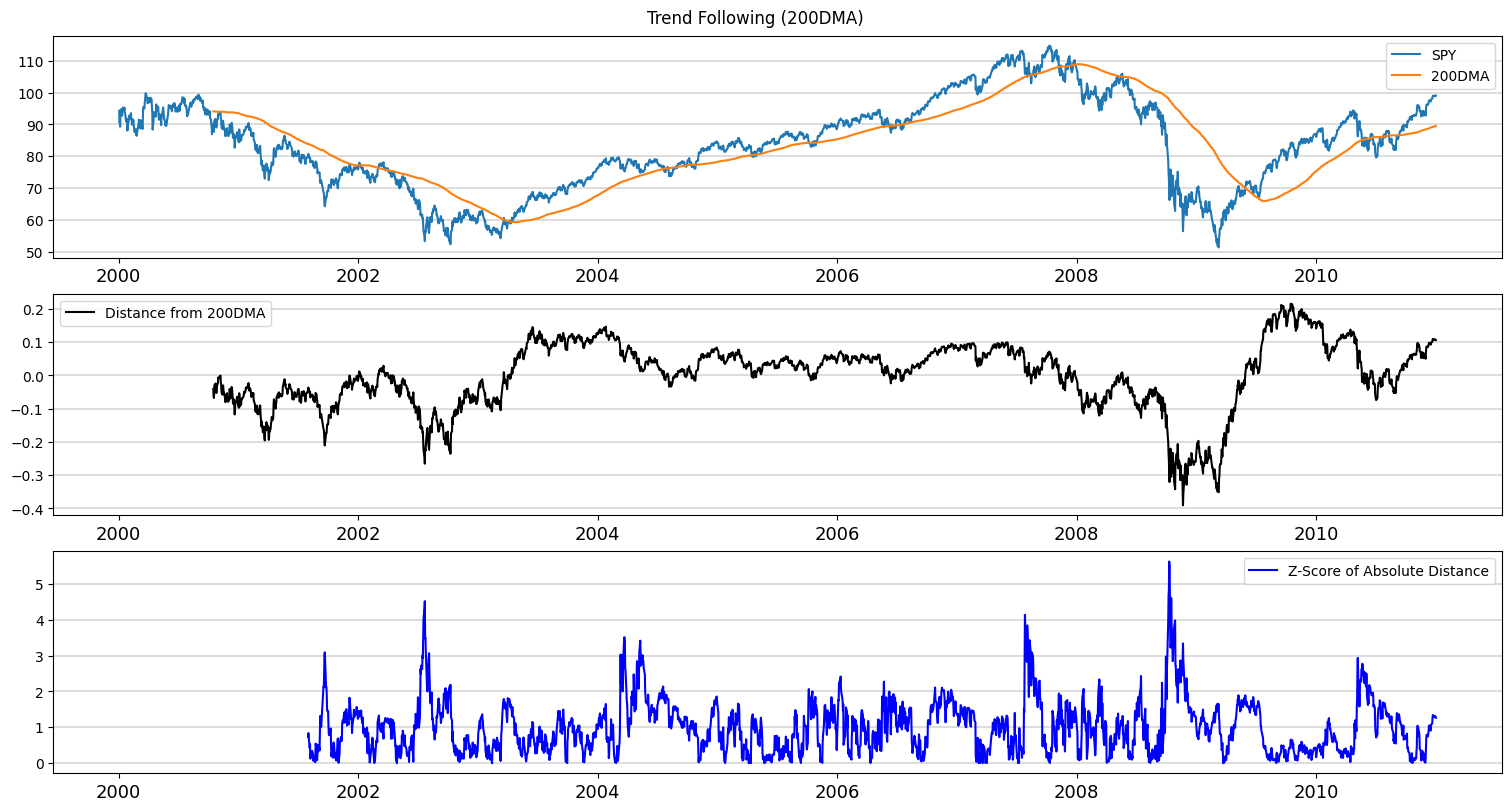

In [4]:
trend_following_sig["200DMA"] = trend_following_sig[["Adj Close"]].rolling(200).mean()
trend_following_sig["dist_200dma"] = (trend_following_sig["Adj Close"] / trend_following_sig["200DMA"])  - 1
z_200dma_dist_obj = trend_following_sig["dist_200dma"].abs().rolling(200)
trend_following_sig["Z"] = (trend_following_sig["dist_200dma"].abs() - z_200dma_dist_obj.mean()) / z_200dma_dist_obj.std()

# Create signal
trend_following_sig["Direction"] = np.where(trend_following_sig.dist_200dma >= 0, 1, -1)
trend_following_sig["Direction_Adj"] = trend_following_sig["Direction"].shift(1)

fig, ax = plt.subplots(3, 1, figsize = (15, 8), constrained_layout = True, sharex = True)

ax[0].plot(trend_following_sig["Adj Close"], label = "SPY")
ax[0].plot(trend_following_sig["200DMA"], label = "200DMA")
ax[0].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[0].legend()
ax[0].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[1].plot(trend_following_sig["dist_200dma"], label = "Distance from 200DMA", color = "black")
ax[1].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[1].legend()
ax[1].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)

ax[2].plot(trend_following_sig.Z.abs(), label = "Z-Score of Absolute Distance", color = "blue")
# ax[2].plot(trend_following_sig.Size, label = "Position Sizing", linestyle = "dotted", color = "red")
ax[2].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[2].legend()
ax[2].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
fig.suptitle("Trend Following (200DMA)")

In [5]:
trend_following_strat = (trend_following_sig["Direction_Adj"] * trend_following_sig["Adj Close"].pct_change()).dropna()
trend_following_strat.name = "Trend_Fol"

In [6]:
functions.exportPerformanceMetrics(trend_following_strat, trend_following_sig["Adj Close"].pct_change().dropna())

,Strategy,Benchmark
Performance Metrics (2000-01-04 till 2010-12-31),,
CAGR %,1.61%,0.45%
Volatility,22.07%,22.07%
Sharpe Ratio,0.07,0.02
Sortino Ratio,0.09,0.03
Max Drawdown %,-35.19%,-55.19%
Return/MaxDrawdown,0.05,0.01


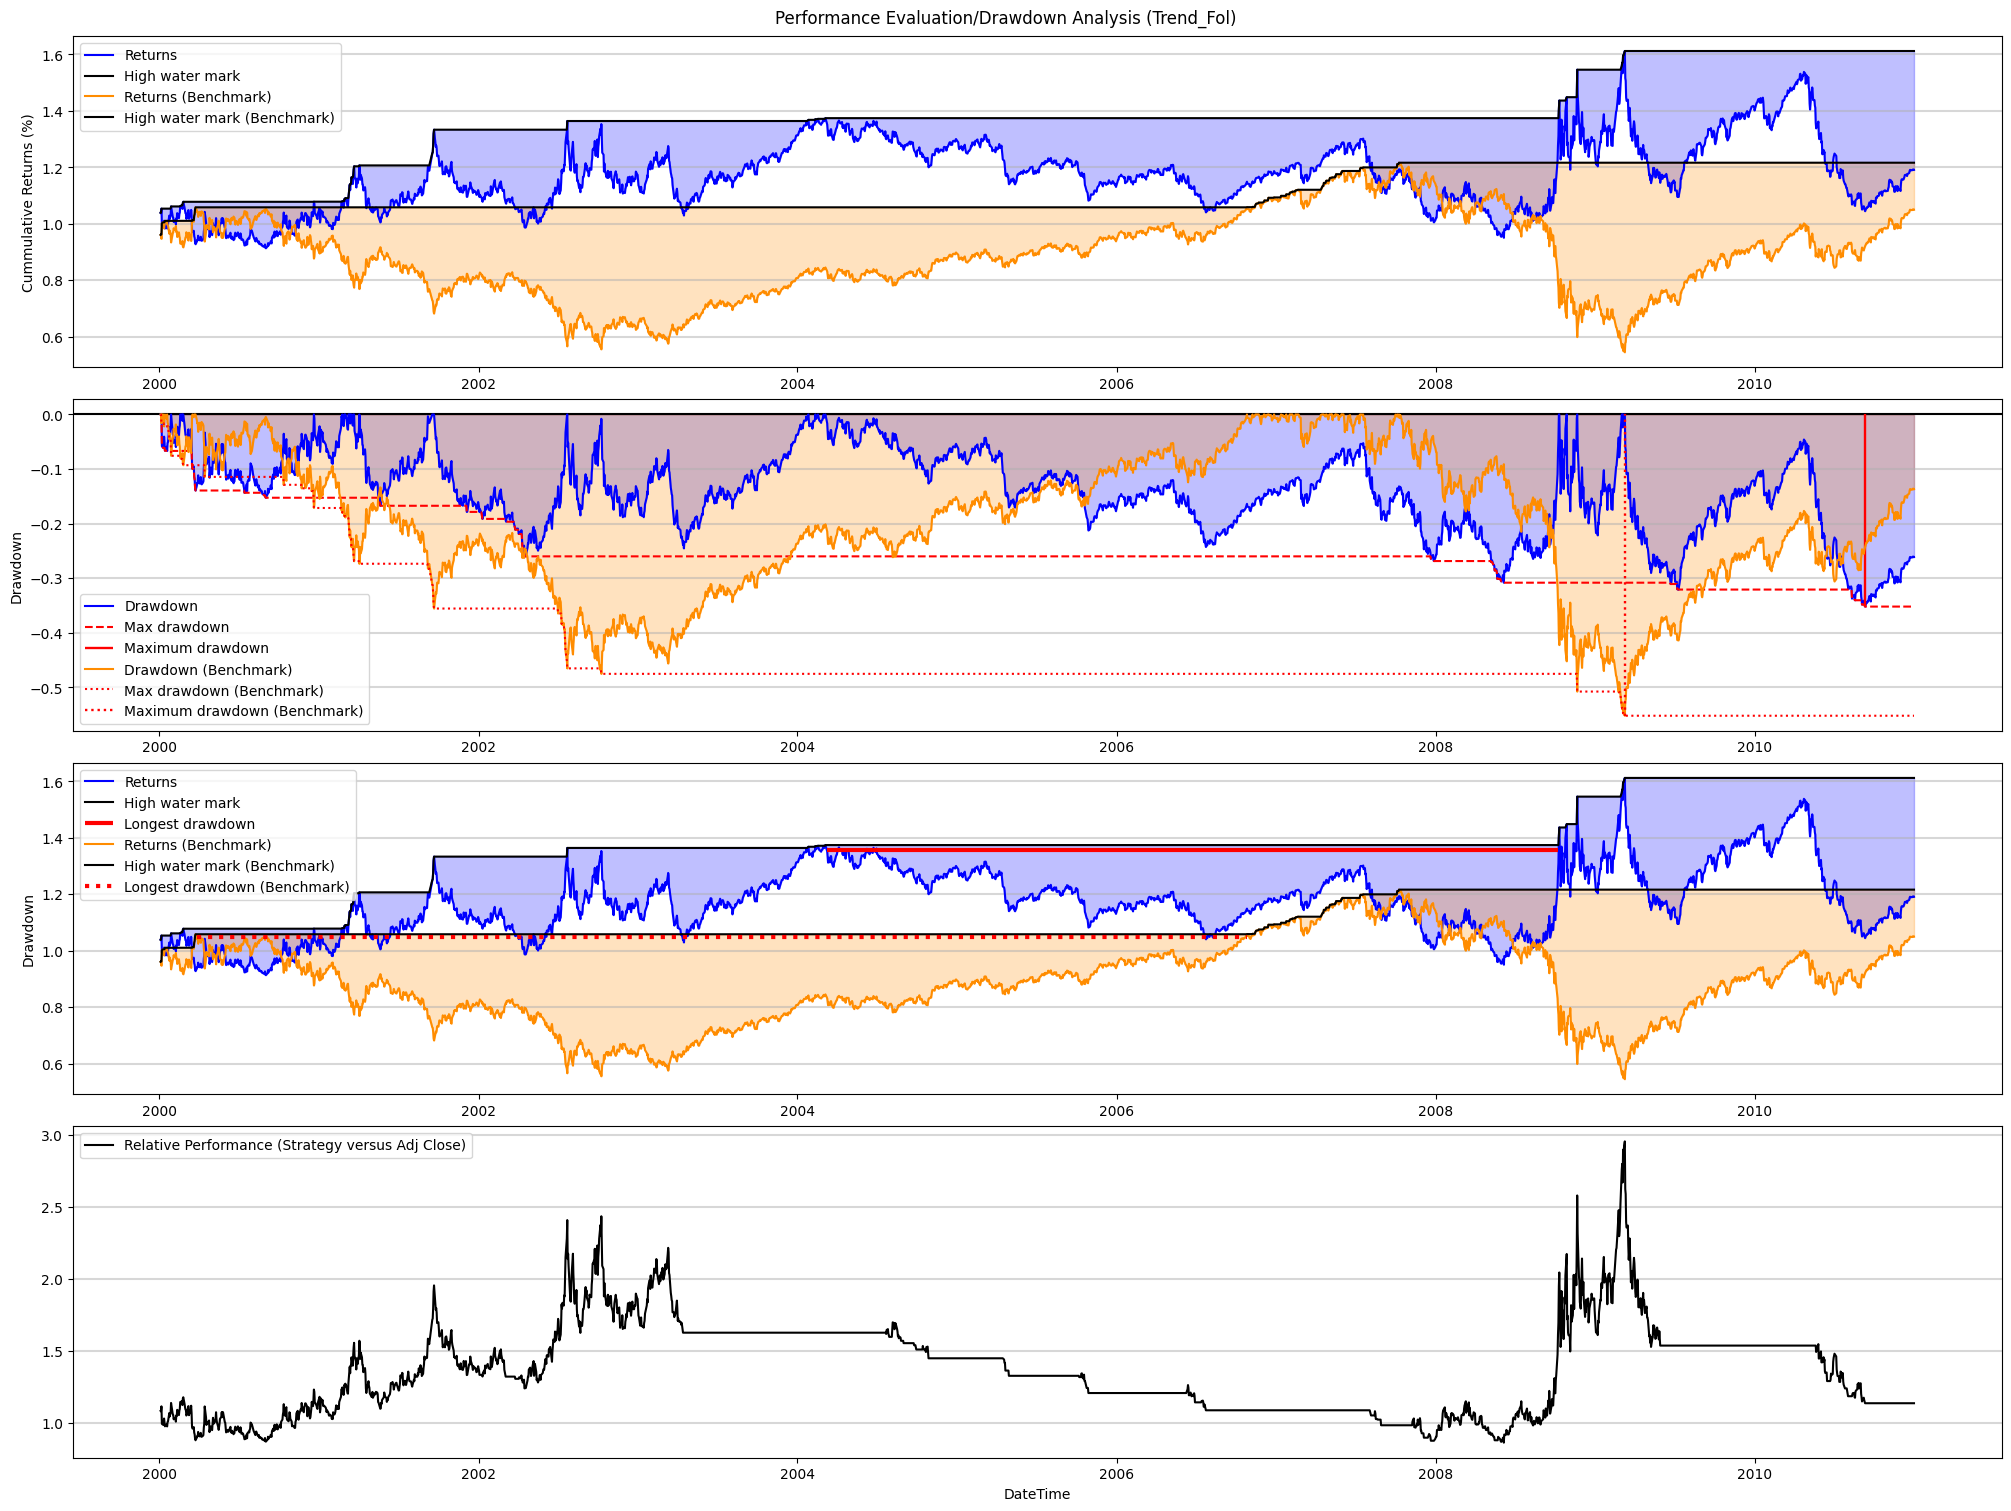

In [7]:
functions.drawdownCharts(trend_following_strat, trend_following_sig["Adj Close"].pct_change().dropna(), includeBenchmark=True, showPlot=True)

### Momentum

In [8]:
px_mom = functions.computeMomentum(pd.DataFrame(spy['Adj Close']), 1, "2000-01-03", end = "2010-12-31", asset_name = "SPY US Equity")
px_mom_3 = functions.computeMomentum(pd.DataFrame(spy['Adj Close']), 3, "2000-01-03", end = "2010-12-31", asset_name = "SPY US Equity")
px_mom_6 = functions.computeMomentum(pd.DataFrame(spy['Adj Close']), 6, "2000-01-03", end = "2010-12-31", asset_name = "SPY US Equity")

#### Autocorrelation of returns 

<Axes: xlabel='Date'>

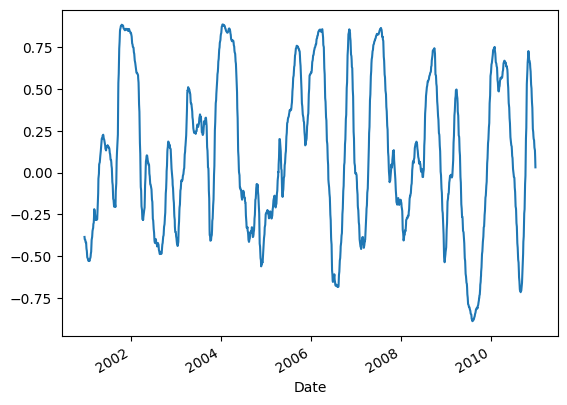

In [9]:
px_mom_6[["Price", "Mth_Prior_6_Price"]].rolling(120).corr().dropna().xs('Price', level = 1)['Mth_Prior_6_Price'].plot()

In [10]:
px_mom ['Signal'] = np.where(px_mom.Mth_Prior_1_Return >= 0, 1, 0)
px_mom_3['Signal'] = np.where(px_mom_3.Mth_Prior_3_Return >= 0, 1, 0)
px_mom_6['Signal'] = np.where(px_mom_6.Mth_Prior_6_Return >= 0, 1, 0)

sig_1_mo = px_mom.Signal
sig_1_mo.name = 'PX_Mom_1'
sig_3_mo = px_mom_3.Signal
sig_3_mo.name = 'PX_Mom_3'
sig_6_mo = px_mom_6.Signal
sig_6_mo.name = 'PX_Mom_6'

all_px_mom_sig = pd.concat([sig_1_mo, sig_3_mo, sig_6_mo], axis=1)
all_px_mom_sig['Sig_Strength'] = all_px_mom_sig.sum(axis=1)
all_px_mom_sig['Sig_Strength_Adj'] = all_px_mom_sig['Sig_Strength'].shift(1)
all_px_mom_sig['SPY_ret'] = spy['Adj Close'].pct_change()
all_px_mom_sig.dropna(inplace=True)
all_px_mom_sig['Positioning'] = all_px_mom_sig['Sig_Strength_Adj'].map({0 : 0.1, 1 : 0.4, 2 : 0.6, 3: 0.9})
all_px_mom_sig['Portfolio'] = all_px_mom_sig['Positioning'] * all_px_mom_sig['SPY_ret']
all_px_mom_sig

,PX_Mom_1,PX_Mom_3,PX_Mom_6,Sig_Strength,Sig_Strength_Adj,SPY_ret,Positioning,Portfolio
Date,,,,,,,,
2000-07-03,0,0.0,1.0,1.0,1.0,0.013767,0.4,0.005507
2000-07-05,0,0.0,1.0,1.0,1.0,-0.018035,0.4,-0.007214
2000-07-06,0,0.0,1.0,1.0,1.0,0.007779,0.4,0.003112
2000-07-07,1,0.0,1.0,2.0,1.0,0.016080,0.4,0.006432
2000-07-10,1,0.0,1.0,2.0,2.0,-0.001688,0.6,-0.001013
...,...,...,...,...,...,...,...,...
2010-12-27,1,1.0,1.0,3.0,3.0,0.000398,0.9,0.000358
2010-12-28,1,1.0,1.0,3.0,3.0,0.001433,0.9,0.001289
2010-12-29,1,1.0,1.0,3.0,3.0,0.000715,0.9,0.000644


In [21]:
functions.exportPerformanceMetrics(all_px_mom_sig["Portfolio"], all_px_mom_sig["SPY_ret"])

,Portfolio,SPY_ret
Performance Metrics (2000-07-03 till 2010-12-31),,
CAGR %,1.51%,0.43%
Volatility,9.02%,21.84%
Sharpe Ratio,0.17,0.02
Sortino Ratio,0.21,0.03
Max Drawdown %,-24.87%,-55.19%
Return/MaxDrawdown,0.06,0.01


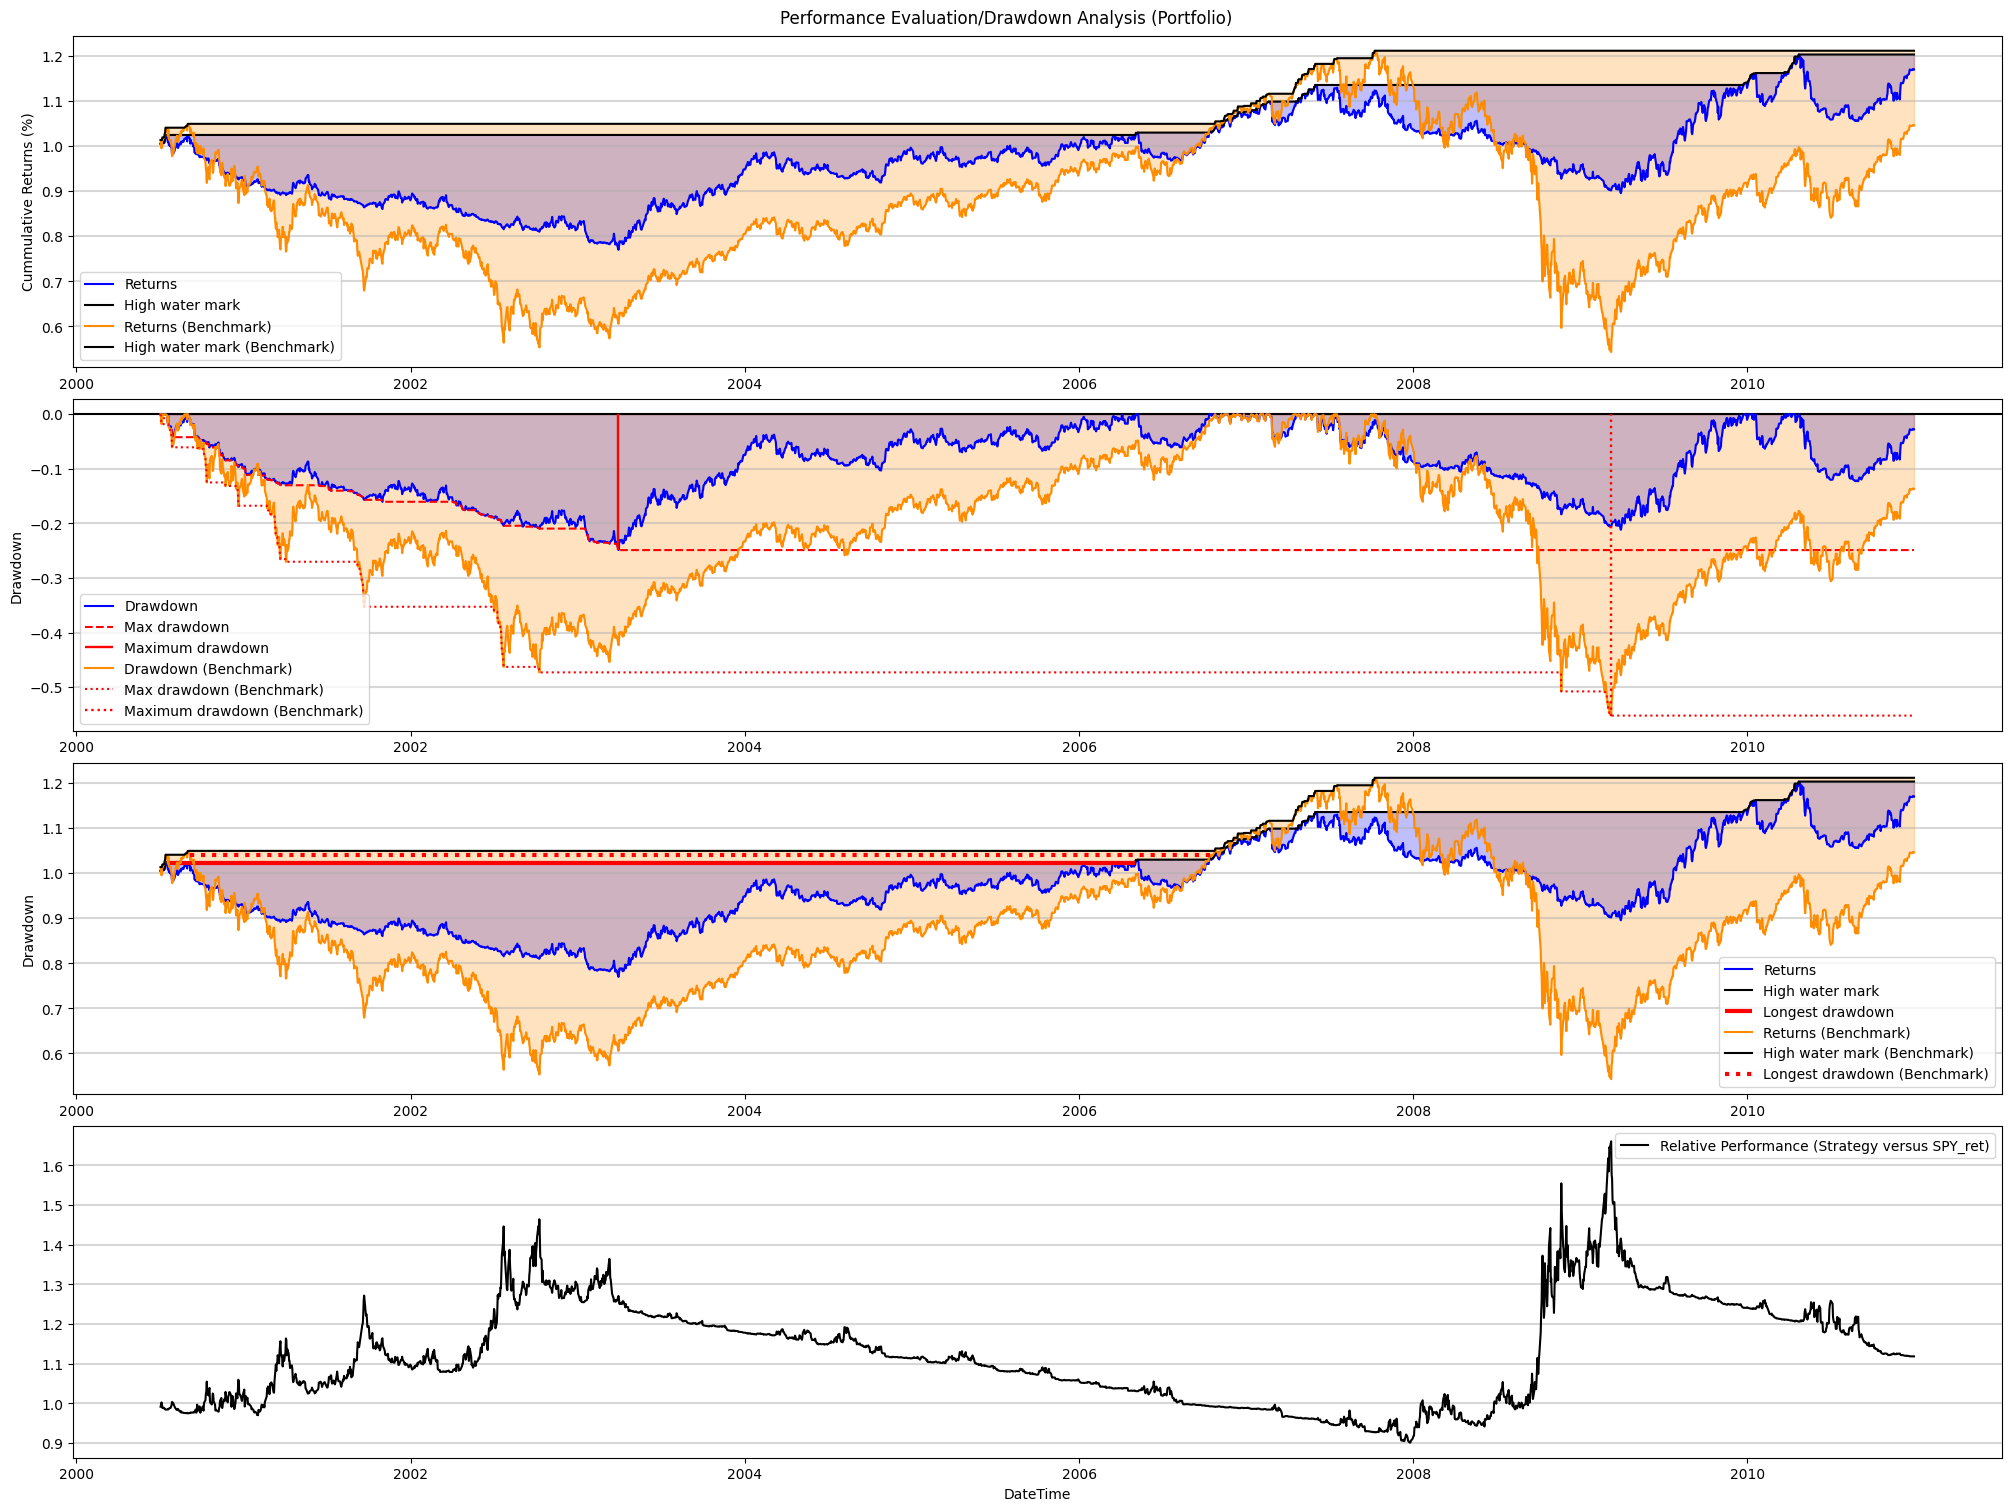

In [22]:
functions.drawdownCharts(all_px_mom_sig["Portfolio"], benchmark = all_px_mom_sig["SPY_ret"], includeBenchmark = True, showPlot=True)

In [13]:
nav_numbers = pd.read_excel("nav_sample.xlsx")
avm = nav_numbers[["Date_Strat", "AVM GOF A"]].dropna()
avm.rename(columns = {'Date_Strat':'Date'}, inplace=True)
avm.set_index('Date', inplace=True)
bnchmk = nav_numbers[["Date_Indx", "BHMACR Index Adj"]].dropna()
bnchmk.rename(columns = {'Date_Indx':'Date'}, inplace=True)
bnchmk.set_index('Date', inplace=True)

# Both strategy and benchmark have to share the same end of month.
avm = avm.resample('BM').last()
bnchmk = bnchmk.resample('BM').last()
nav_numbers

,Date_Strat,AVM GOF A,Date_Indx,BHMACR Index,BHMACR Return,BHMACR Index Adj,BHMACR Return Check
0,2016-10-31,100.00,2013-12-31,1000.00,NaN,NaN,NaN
1,2016-11-30,98.81,2014-01-31,989.10,-1.090000,NaN,NaN
2,2016-12-30,100.67,2014-02-28,1002.91,1.396219,NaN,NaN
3,2017-01-31,102.04,2014-03-31,993.89,-0.899383,NaN,NaN
4,2017-02-28,104.36,2014-04-30,994.63,0.074455,NaN,NaN
...,...,...,...,...,...,...,...
112,NaT,NaN,2023-04-28,1219.02,0.470613,117.328534,0.470613
113,NaT,NaN,2023-05-31,1214.66,-0.357664,116.908891,-0.357664
114,NaT,NaN,2023-06-30,1228.82,1.165758,118.271767,1.165758
115,NaT,NaN,2023-07-31,1238.48,0.786120,119.201525,0.786120


In [23]:
functions.exportPerformanceMetrics(avm['AVM GOF A'].pct_change().dropna(), bnchmk['BHMACR Index Adj'].pct_change().dropna(), freq='M')

,AVM GOF A,BHMACR Index Adj
Performance Metrics (2016-11-30 till 2023-08-31),,
CAGR %,8.70%,2.44%
Volatility,4.70%,4.74%
Sharpe Ratio,1.85,0.51
Sortino Ratio,2.22,0.84
Max Drawdown %,-7.89%,-9.21%
Return/MaxDrawdown,1.10,0.26


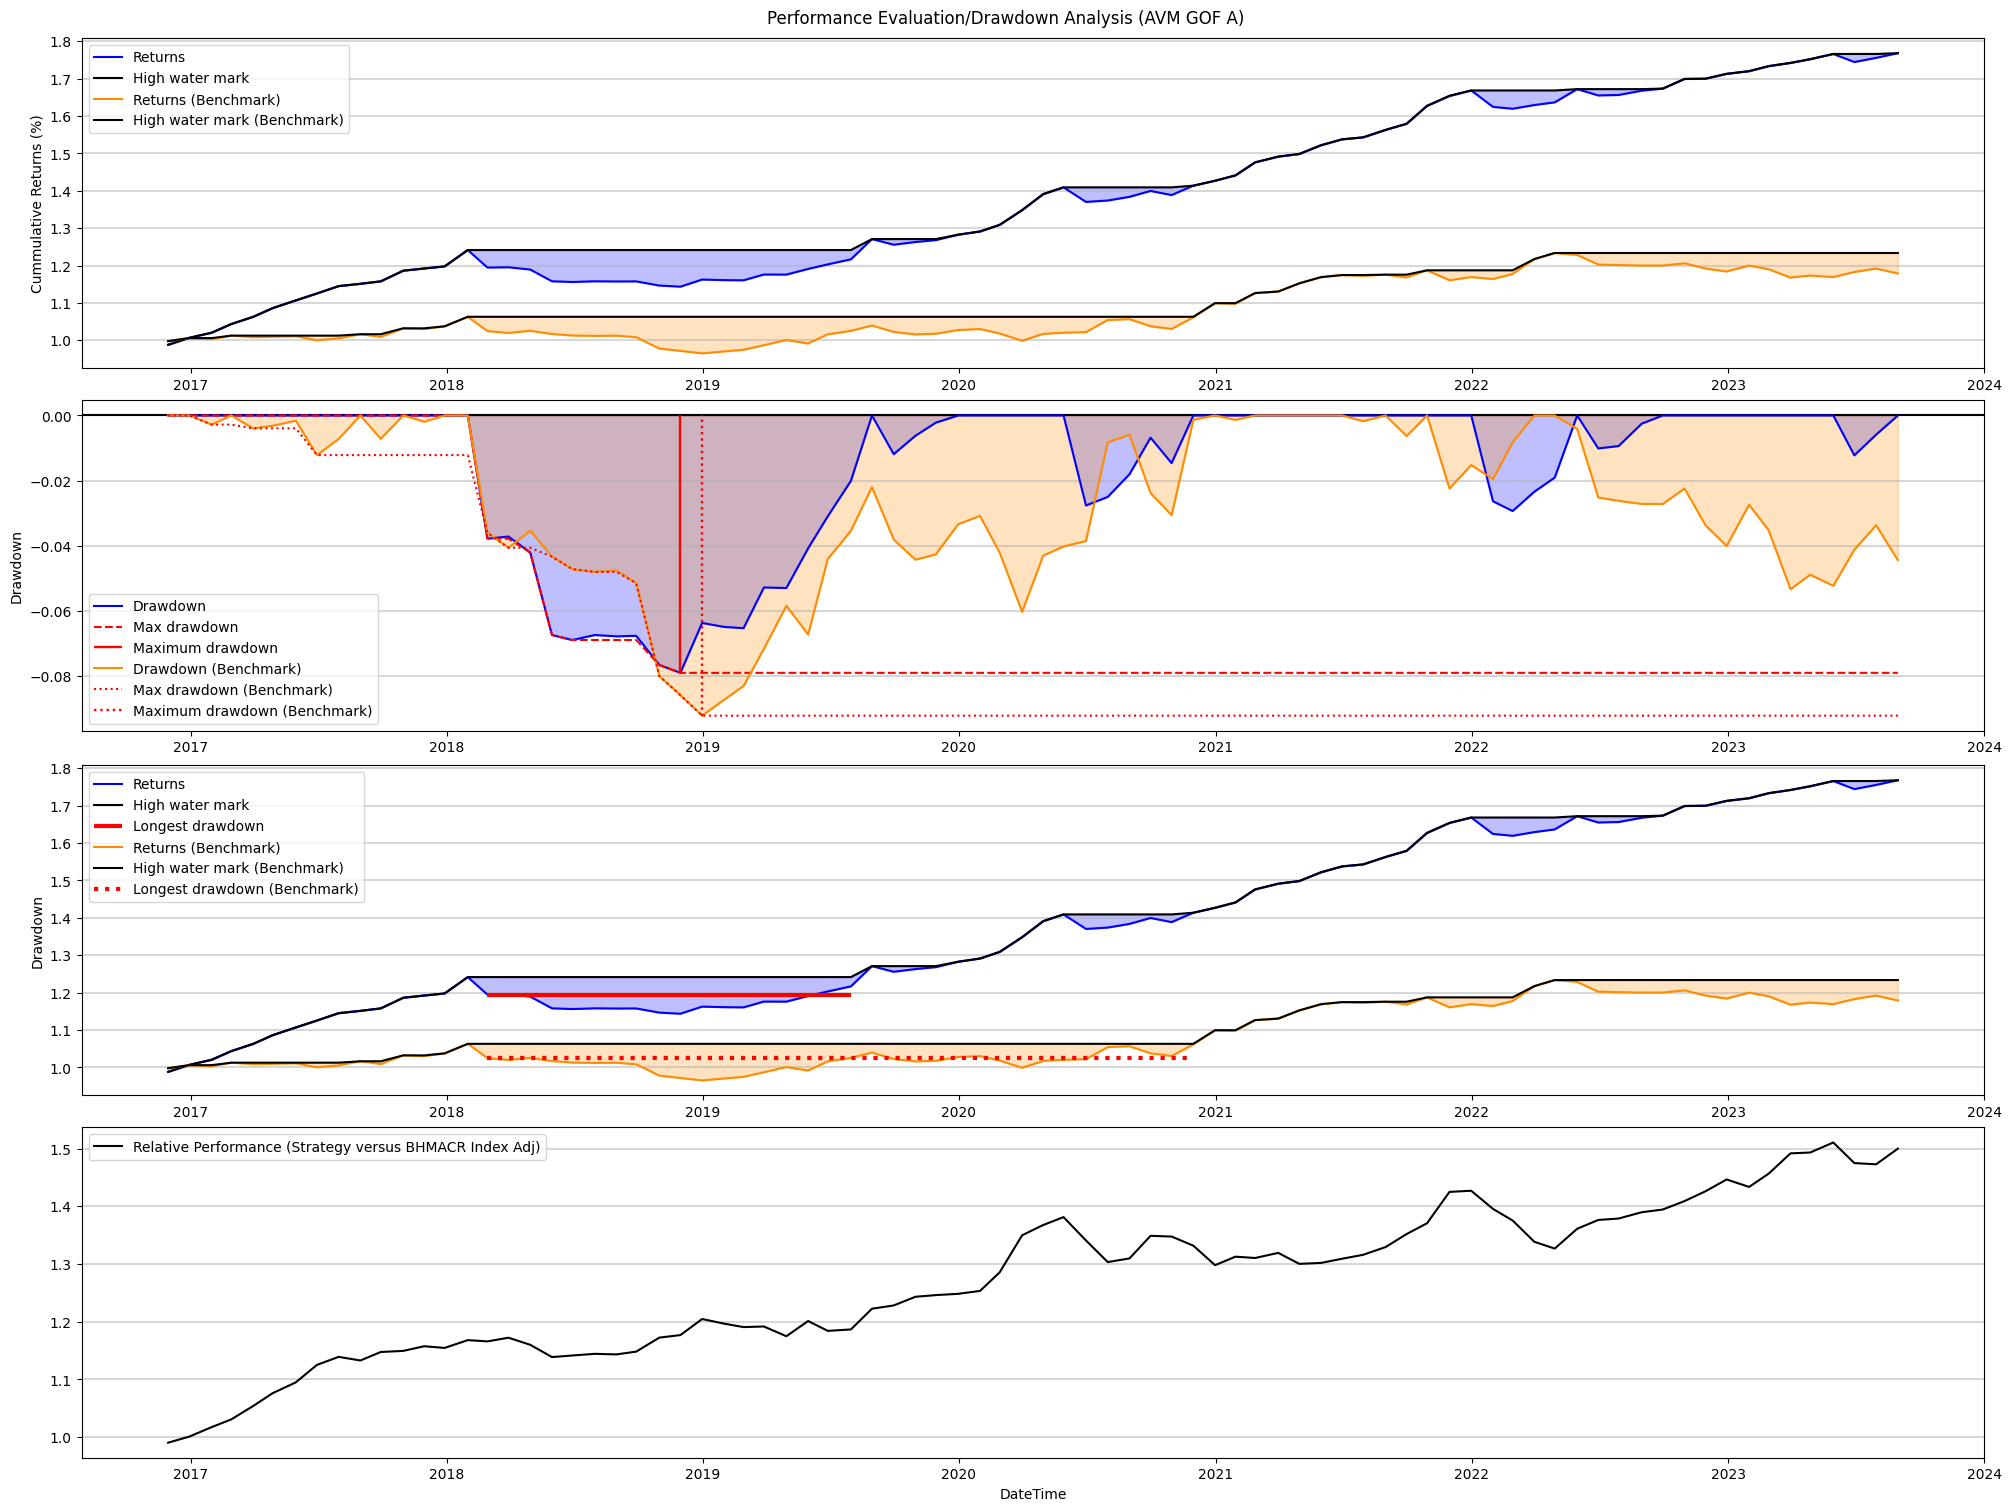

In [15]:
functions.drawdownCharts(avm['AVM GOF A'].pct_change(), bnchmk['BHMACR Index Adj'].pct_change(), includeBenchmark=True, showPlot=True)

### PCA for Term Structure Analysis

In [16]:
start_dt = '2000-01-01'
end_dt = datetime.today().strftime("%Y-%m-%d")

df = []
ids = ['DGS{}'.format(i) for i in ['3MO','6MO',1,2,5,7,10,20,30]]
for s in ids:
    df.append(fred.get_series(s,observation_start = start_dt, observation_end = end_dt)/100)
df = pd.concat(df,axis=1)
df.columns = ids
df.fillna(method = 'ffill', inplace=True)

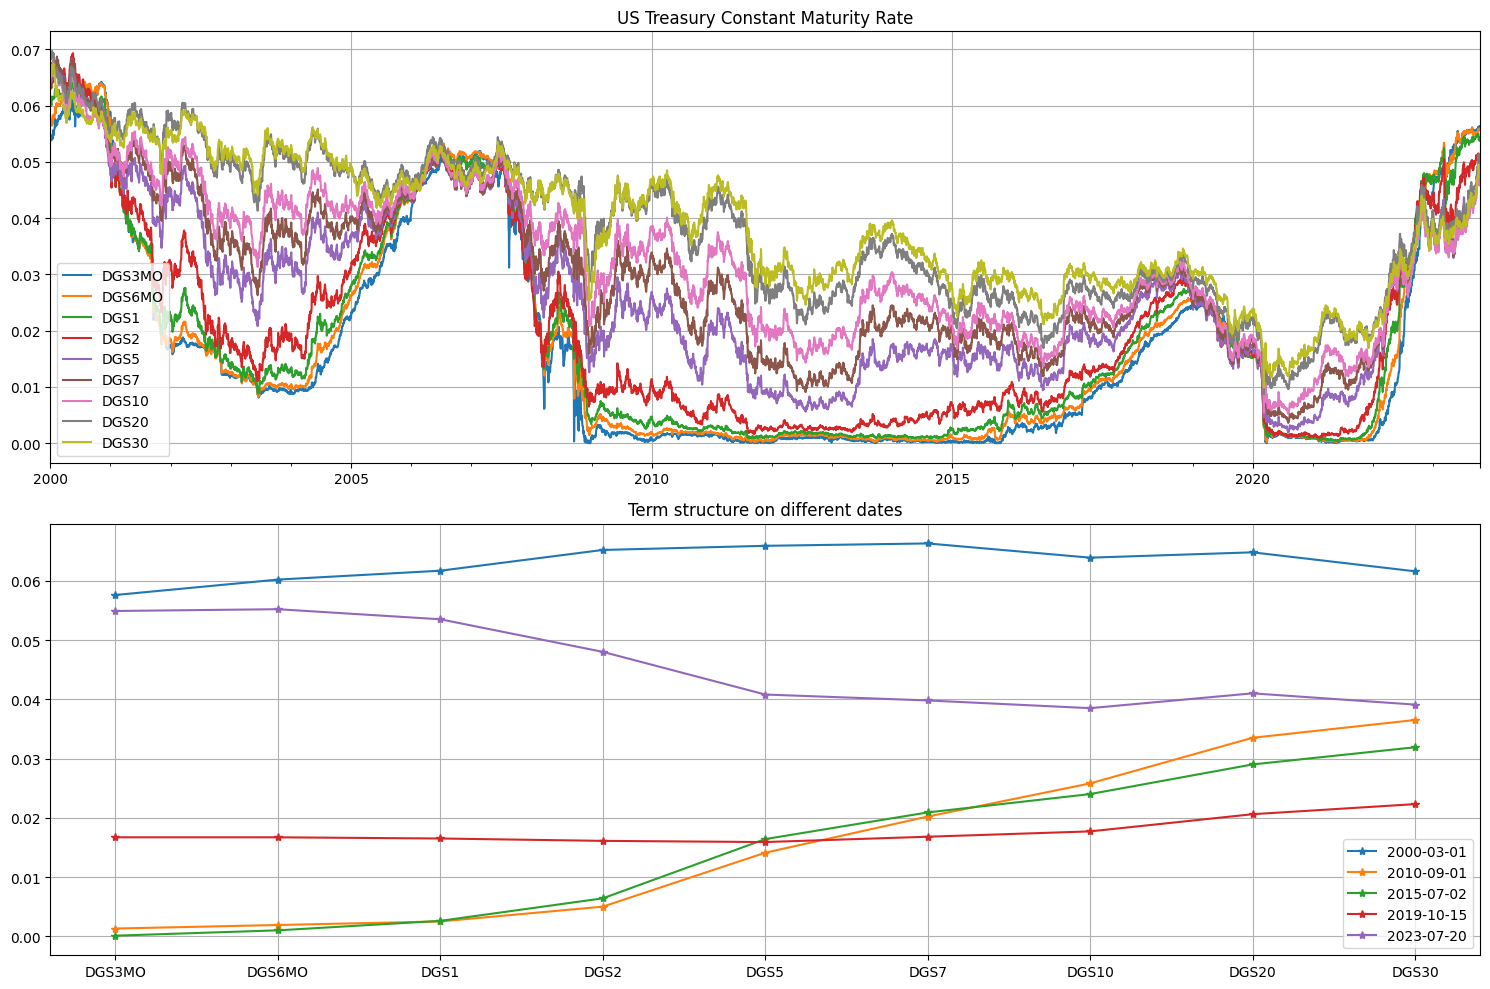

In [17]:
fig,(ax,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(15,10))
df.plot(grid=True, title='US Treasury Constant Maturity Rate', ax=ax)
ax.legend(loc = 'best')
x = df.loc[df.index.intersection([datetime(2000, 3, 1), datetime(2010,9,1), datetime(2015,7,2), datetime(2019,10,15), datetime(2023, 7, 20)])]
x.index = [t.date() for t in x.index]
ax2.plot(x.T.index,x.T,marker='*')
ax2.legend(x.index)
ax2.grid(True)
ax2.set_title('Term structure on different dates')
fig.tight_layout()

#### Assets individually extracted from BBG

In [30]:
macro_factors = pd.read_excel("../Strategies/asset_list1.xlsx")
usd_df = macro_factors[["Date.6", "US 2s10s", "Date.7", "US 5s30s", "Date.8", "BBDXY Curncy", "Date.9", "US2Y", "Date.10", "US5Y", "Date.11", "US10Y", "Date.12", "US30Y"]]
macro_factors.columns, usd_df

(Index(['Date', 'NKY Index', 'Date.1', 'KOSPI2 Index', 'Date.2', 'TWSE Index',
        'Date.3', 'USDKRW', 'Date.4', 'USDTWD', 'Date.5', 'USDJPY', 'Date.6',
        'US 2s10s', 'Date.7', 'US 5s30s', 'Date.8', 'BBDXY Curncy', 'Date.9',
        'US2Y', 'Date.10', 'US5Y', 'Date.11', 'US10Y', 'Date.12', 'US30Y',
        'Date.13', 'KRW1Y', 'Date.14', 'KRW2Y', 'Date.15', 'KRW10Y', 'Date.16',
        'KRW15Y', 'Date.17', 'TWD2Y', 'Date.18', 'TWD5Y', 'Date.19', 'TWD10Y'],
       dtype='object'),
          Date.6  US 2s10s     Date.7  US 5s30s     Date.8  BBDXY Curncy  \
 0    2000-01-03     29.30 2000-01-03      7.95 2000-01-03        100.22   
 1    2000-01-04     13.85 2000-01-04     13.90 2000-01-04        100.41   
 2    2000-01-05     29.55 2000-01-05     11.95 2000-01-05        100.38   
 3    2000-01-06     21.60 2000-01-06     20.95 2000-01-06        100.48   
 4    2000-01-07     15.60 2000-01-07      9.15 2000-01-07        100.72   
 ...         ...       ...        ...       ...   

In [40]:
sDate = datetime.strptime("2000-01-03", "%Y-%m-%d")
eDate = datetime.strptime("2023-10-16", "%Y-%m-%d")
full_date_range = pd.date_range(sDate, eDate, freq = 'd').to_list()
full_date_range_df = pd.DataFrame(index=full_date_range, columns=['All_Days'])
full_date_range_df.reset_index(inplace=True)
full_date_range_df.rename(columns = {'index':'Date'}, inplace=True)

def fill_missing(df, full_range):
    
    dateVal, item_nm = df.columns[0], df.columns[1]
    df.rename(columns = {dateVal:'Date'}, inplace=True)
    
    combined_df = pd.merge(df, full_range, on = 'Date', how='right')

    return combined_df

full_1 = fill_missing(usd_df[["Date.6", "US 2s10s"]], full_date_range_df)

,Date,All_Days
0,2000-01-03,NaN
1,2000-01-04,NaN
2,2000-01-05,NaN
3,2000-01-06,NaN
4,2000-01-07,NaN
...,...,...
8683,2023-10-12,NaN
8684,2023-10-13,NaN
8685,2023-10-14,NaN
8686,2023-10-15,NaN


In [ ]:
import pdblp

### Establish connection to Bloomberg:

con = pdblp.BCon( debug = False , port = 8194 , timeout = 35000 )
con.start()
con.debug = False

In [ ]:
#edit data points
start_dt = '20080601'
end_dt = date.today().strftime("%Y%m") + str(calendar.monthrange(date.today().year, date.today().month)[1])

def my_df_format(df):
    """
    Function to restructure Bloomberg dataframe
    
    """
    df.columns = df.columns.get_level_values(0)
    df.reset_index(drop = True)
    df.index.name = None
    df.reset_index(level = 0, inplace = True)
    df.rename(columns = {'index': 'Date'}, inplace=True)
    df.rename_axis(None, axis = 1 , inplace = True)  
    # df['MM_YYYY'] = df['Date'].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d").strftime("%b-%Y"))

In [ ]:
asset_list = ["SPX Index", "KOSPI2 Index", "TWSE Index", "USDTWD Curncy", "USDKRW Curncy", "USDCNH Curncy", 
              "USDCNY Curncy", "DXY Curncy", "USYC2Y10 Index", "USYC5Y30 Index", "USGG2YR Index", "BBDXY Curncy",
              "USGG5YR Index", "USGG10YR Index", "USGGT10Y Index", "KWSWNI1 BGN Curncy", "KWSWNI5 BGN Curncy", 
              "KWSWNI10 BGN Curncy", "KWSWNI15 BGN Curncy", "TDSWNI2 BGN Curncy", "TDSWNI5 BGN Curncy", 
              "TDSWNI10 BGN Curncy", "TDSWNI15 BGN Curncy"]

fwd_pt = ["JPY3M Curncy", "KWN3M Curncy", "EUR3M Curncy"]

# Not run since no access to Bloomberg
df = con.bdh(asset_list, "PX_LAST", start_dt, end_dt)
my_df_format(df)

df_2 = con.bdh(fwd_pt, "PX_MID", start_dt, end_dt)
my_df_format(df_2)

In [3]:
df = pd.read_csv("assetlist.csv", index_col=False)
df.set_index('Date', inplace=True)
df_2 = pd.read_csv("carry.csv", index_col=False)
df_2.set_index('Date', inplace=True)
df.columns, df_2.columns

(Index(['Unnamed: 0', 'SPX Index', 'USYC2Y10 Index', 'KOSPI2 Index',
        'TWSE Index', 'USYC5Y30 Index', 'USGG2YR Index', 'USDTWD Curncy',
        'USDKRW Curncy', 'USDCNH Curncy', 'USDCNY Curncy', 'BBDXY Curncy',
        'USGG5YR Index', 'DXY Curncy', 'KWSWNI5 BGN Curncy', 'USGG10YR Index',
        'USGGT10Y Index', 'KWSWNI10 BGN Curncy', 'KWSWNI15 BGN Curncy',
        'TDSWNI2 BGN Curncy', 'TDSWNI5 BGN Curncy', 'KWSWNI1 BGN Curncy',
        'TDSWNI10 BGN Curncy', 'TDSWNI15 BGN Curncy'],
       dtype='object'),
 Index(['Unnamed: 0', 'JPY3M Curncy', 'KWN3M Curncy', 'EUR3M Curncy'], dtype='object'))

#### Analyzing regimes of US treasury curves at daily frequency

In [65]:
rates_2 = df[["USGG2YR Index", "USGG10YR Index","USYC2Y10 Index"]].copy()
rates_2['2Y_Diff'] = rates_2['USGG2YR Index'].diff()
rates_2['10Y_Diff'] = rates_2['USGG10YR Index'].diff()
rates_2['2s10s_diff'] = rates_2['10Y_Diff'] - rates_2['2Y_Diff']
rates_2['Bear_Steepen'] = np.where((rates_2['2Y_Diff'] > 0) & (rates_2['10Y_Diff'] > 0) & (rates_2['2s10s_diff'] > 0), 1, 0)
rates_2['Bear_Flatten'] = np.where((rates_2['2Y_Diff'] > 0) & (rates_2['10Y_Diff'] > 0) & (rates_2['2s10s_diff'] < 0), 1, 0)
rates_2['Bull_Steepen'] = np.where((rates_2['2Y_Diff'] < 0) & (rates_2['10Y_Diff'] < 0) & (rates_2['2s10s_diff'] > 0), 1, 0)
rates_2['Bull_Flatten'] = np.where((rates_2['2Y_Diff'] < 0) & (rates_2['10Y_Diff'] < 0) & (rates_2['2s10s_diff'] < 0), 1, 0)

Text(0.5, 1.0, '2s10s Daily Change')

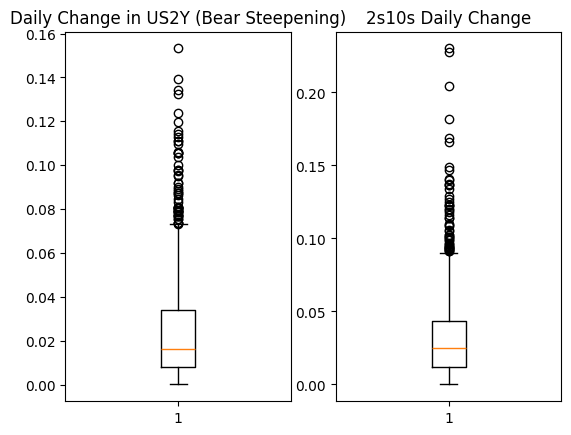

In [64]:
fig, (ax, ax1) = plt.subplots(1, 2)
ax.boxplot(rates_2[rates_2['Bear_Steepen'] == 1]['2Y_Diff'])
ax.set_title('Daily Change in US2Y (Bear Steepening)')
ax1.boxplot(rates_2[rates_2['Bear_Steepen'] == 1]['2s10s_diff'])
ax1.set_title('2s10s Daily Change')

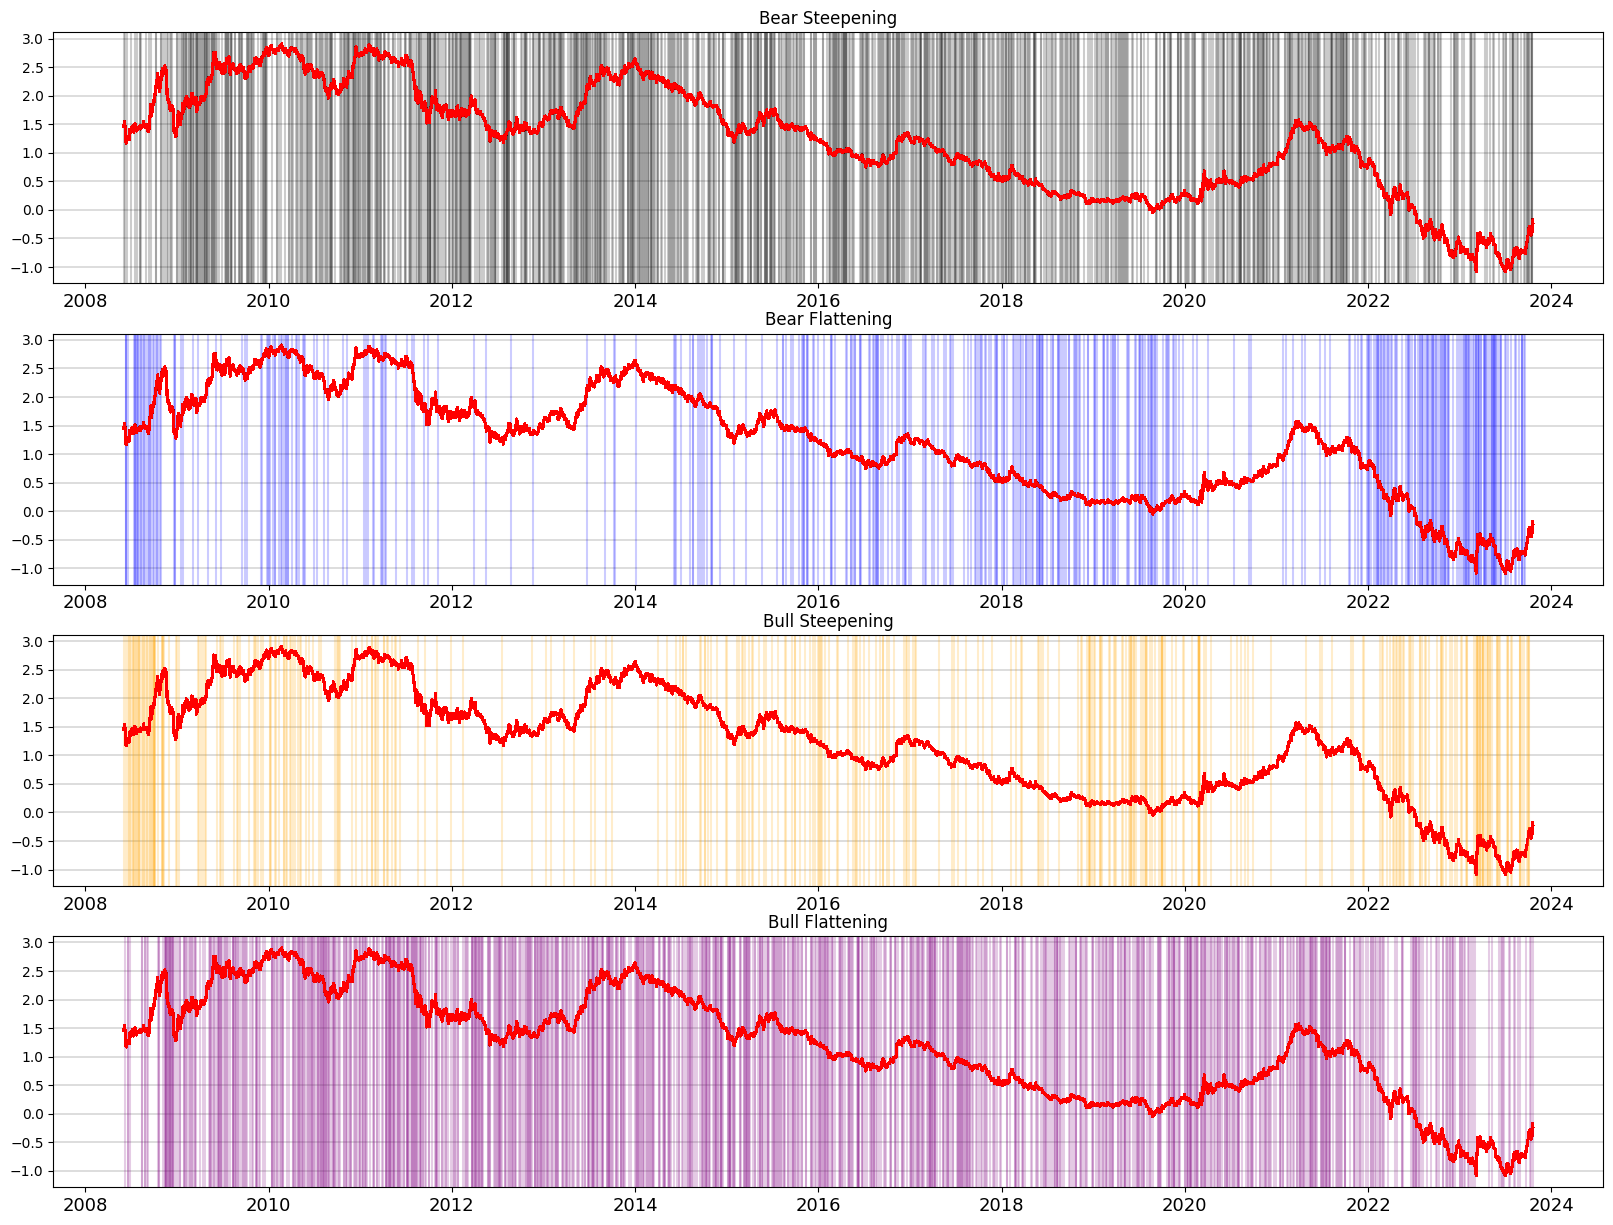

In [83]:
rates_2.index = pd.to_datetime(rates_2.index)
fig, ax = plt.subplots(4, 1, figsize = (20, 15), sharex=True)
for i in rates_2[rates_2.Bear_Steepen == 1].index:
    ax[0].axvline(i, color = "black", alpha = 0.2)
    ax[0].plot(rates_2[["USYC2Y10 Index"]] / 100, color = "red", label = "2s10s")
    ax[0].grid(axis = 'y', linewidth = 1.2, alpha = 0.5)
    ax[0].set_title("Bear Steepening")
    ax[0].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)

for i in rates_2[rates_2.Bear_Flatten == 1].index:
    ax[1].axvline(i, label = "Bear Flattening", color = "blue", alpha = 0.2)
    ax[1].plot(rates_2[["USYC2Y10 Index"]] / 100, color = "red", label = "2s10s")
    ax[1].grid(axis = 'y', linewidth = 1.2, alpha = 0.5)
    ax[1].set_title("Bear Flattening")
    ax[1].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)

for i in rates_2[rates_2.Bull_Steepen == 1].index:
    ax[2].axvline(i, label = "Bull Steepening", color = "orange", alpha = 0.2)
    ax[2].plot(rates_2[["USYC2Y10 Index"]] / 100, color = "red", label = "2s10s")
    ax[2].grid(axis = 'y', linewidth = 1.2, alpha = 0.5)
    ax[2].set_title("Bull Steepening")
    ax[2].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)

for i in rates_2[rates_2.Bull_Flatten == 1].index:
    ax[3].axvline(i, label = "Bull Flattening", color = "purple", alpha = 0.2)
    ax[3].plot(rates_2[["USYC2Y10 Index"]] / 100, color = "red", label = "2s10s")
    ax[3].grid(axis = 'y', linewidth = 1.2, alpha = 0.5)
    ax[3].set_title("Bull Flattening")
    ax[3].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)

plt.show()

In [99]:
freq_scenarios = pd.DataFrame({'Scenarios' : [rates_2[rates_2.Bear_Steepen == 1].shape[0], 
                                              rates_2[rates_2.Bull_Steepen == 1].shape[0],
                                              rates_2[rates_2.Bear_Flatten == 1].shape[0],
                                              rates_2[rates_2.Bull_Flatten == 1].shape[0]]}, 
                                              index = ['Bear Steepen', 'Bull Steepen', 'Bear Flatten', 'Bull Flatten'])
freq_scenarios

,Scenarios
Bear Steepen,1091
Bull Steepen,364
Bear Flatten,431
Bull Flatten,1078


#### Analyzing regimes of US treasury curves at monthly frequency

##### Get monthly dates

In [284]:
sDate = datetime(2008, 6, calendar.monthrange(2008, 6)[1]).strftime("%Y-%m-%d")
eDate = datetime(2023, 9, calendar.monthrange(2023, 9)[1]).strftime("%Y-%m-%d")
full_date_range = pd.date_range(sDate, eDate, freq = 'd').to_list()
full_date_range_df = pd.DataFrame(index=full_date_range, columns=['All_Days'])
full_date_range_df.reset_index(inplace=True)
full_date_range_df.rename(columns = {'index':'Date'}, inplace=True)
full_date_range_df.Date = pd.to_datetime(full_date_range_df.Date)
full_date_range_df.set_index('Date', inplace=True)
full_date_range_df

,All_Days
Date,
2008-06-30,NaN
2008-07-01,NaN
2008-07-02,NaN
2008-07-03,NaN
2008-07-04,NaN
...,...
2023-09-26,NaN
2023-09-27,NaN
2023-09-28,NaN


In [280]:
rates_mth = df[["USGG2YR Index", "USGG10YR Index","USYC2Y10 Index"]].copy()
rates_mth.index = pd.to_datetime(rates_mth.index)

full_monthly = pd.concat([full_date_range_df, rates_mth], axis=1)
full_monthly.drop(['All_Days'], axis = 1, inplace=True)
full_monthly.fillna(method = 'ffill', inplace=True)
full_monthly_val = full_monthly.resample('M').last()
full_monthly_val['2Y_Diff'] = full_monthly_val['USGG2YR Index'].diff()
full_monthly_val['10Y_Diff'] = full_monthly_val['USGG10YR Index'].diff()
full_monthly_val['2s10s_diff'] = full_monthly_val['10Y_Diff'] - full_monthly_val['2Y_Diff']
full_monthly_val.dropna(inplace=True)
full_monthly_val['Bear_Steepen'] = np.where((full_monthly_val['2Y_Diff'] > 0) & (full_monthly_val['10Y_Diff'] > 0) & (full_monthly_val['2s10s_diff'] > 0), 1, 0)
full_monthly_val['Bear_Flatten'] = np.where((full_monthly_val['2Y_Diff'] > 0) & (full_monthly_val['10Y_Diff'] > 0) & (full_monthly_val['2s10s_diff'] < 0), 1, 0)
full_monthly_val['Bull_Steepen'] = np.where((full_monthly_val['2Y_Diff'] < 0) & (full_monthly_val['10Y_Diff'] < 0) & (full_monthly_val['2s10s_diff'] > 0), 1, 0)
full_monthly_val['Bull_Flatten'] = np.where((full_monthly_val['2Y_Diff'] < 0) & (full_monthly_val['10Y_Diff'] < 0) & (full_monthly_val['2s10s_diff'] < 0), 1, 0)
full_monthly_val['Sum'] = full_monthly_val[['Bear_Steepen', 'Bear_Flatten', 'Bull_Steepen', 'Bull_Flatten']].sum(axis = 1)

In [282]:
freq_scenarios_mth = pd.DataFrame({'Scenarios' : [full_monthly_val[full_monthly_val.Bear_Steepen == 1].shape[0], 
                                              full_monthly_val[full_monthly_val.Bull_Steepen == 1].shape[0],
                                              full_monthly_val[full_monthly_val.Bear_Flatten == 1].shape[0],
                                              full_monthly_val[full_monthly_val.Bull_Flatten == 1].shape[0]]}, 
                                              index = ['Bear Steepen', 'Bull Steepen', 'Bear Flatten', 'Bull Flatten'])
freq_scenarios_mth

,Scenarios
Bear Steepen,49
Bull Steepen,15
Bear Flatten,32
Bull Flatten,51


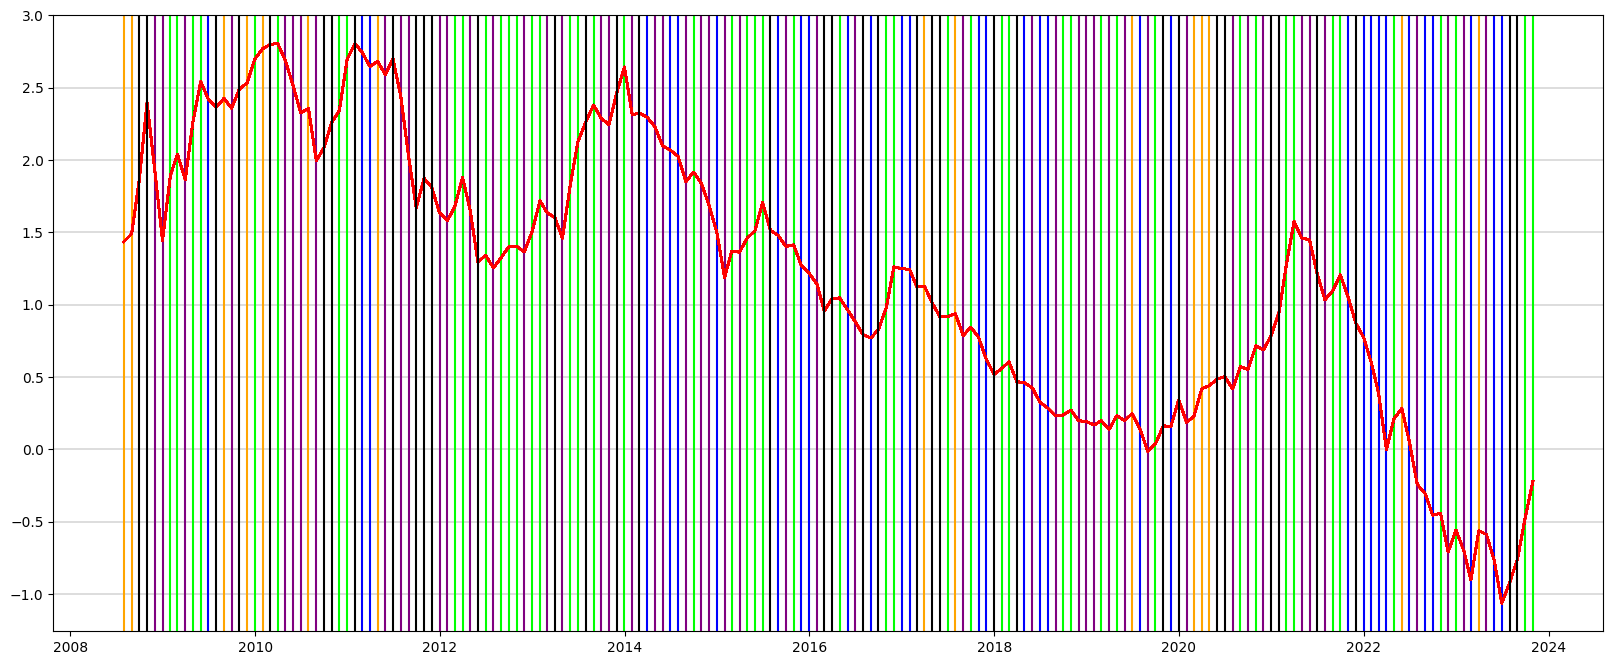

In [283]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
for i in full_monthly_val[full_monthly_val.Bear_Steepen == 1].index:
    ax.axvline(i, color = "lime")
    ax.plot(full_monthly_val[["USYC2Y10 Index"]] / 100, color = "red", label = "2s10s")
    ax.grid(axis = 'y', linewidth = 1.2, alpha = 0.5)
    
for i in full_monthly_val[full_monthly_val.Bear_Flatten == 1].index:
    ax.axvline(i, color = "blue")
    ax.plot(full_monthly_val[["USYC2Y10 Index"]] / 100, color = "red", label = "2s10s")
    ax.grid(axis = 'y', linewidth = 1.2, alpha = 0.5)
    
for i in full_monthly_val[full_monthly_val.Bull_Steepen == 1].index:
    ax.axvline(i, color = "orange")
    ax.plot(full_monthly_val[["USYC2Y10 Index"]] / 100, color = "red", label = "2s10s")
    ax.grid(axis = 'y', linewidth = 1.2, alpha = 0.5)
    
for i in full_monthly_val[full_monthly_val.Bull_Flatten == 1].index:
    ax.axvline(i, color = "purple")
    ax.plot(full_monthly_val[["USYC2Y10 Index"]] / 100, color = "red", label = "2s10s")
    ax.grid(axis = 'y', linewidth = 1.2, alpha = 0.5)

for i in full_monthly_val[full_monthly_val.Sum == 0].index:
    ax.axvline(i, color = "black")
    
plt.show()

In [311]:
pred_var = df[["SPX Index", "KOSPI2 Index", "TWSE Index", "USDTWD Curncy", "USDKRW Curncy", "BBDXY Curncy"]].copy()
pred_var.index = pd.to_datetime(pred_var.index)
pred_var_mth = pd.concat([full_date_range_df, pred_var], axis=1)
pred_var_mth.drop(['All_Days'], axis = 1, inplace=True)
pred_var_mth.fillna(method = 'ffill', inplace=True)
pred_var_mth = pred_var_mth.resample('M').last()
pred_var_mth = pred_var_mth.pct_change()

In [303]:
pd.concat([pred_var_mth, full_monthly_val], axis=1)

,SPX Index,KOSPI2 Index,TWSE Index,USDTWD Curncy,USDKRW Curncy,BBDXY Curncy,USGG2YR Index,USGG10YR Index,USYC2Y10 Index,2Y_Diff,10Y_Diff,2s10s_diff,Bear_Steepen,Bear_Flatten,Bull_Steepen,Bull_Flatten,Sum
Date,,,,,,,,,,,,,,,,,
2008-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-31,-0.009859,-0.044024,-0.066389,0.009093,-0.032408,0.006156,2.5079,3.9462,143.624,-0.1085,-0.0228,0.0857,0.0,0.0,1.0,0.0,1.0
2008-08-31,0.012191,-0.074270,0.003139,0.030135,0.075878,0.050272,2.3669,3.8116,149.074,-0.1410,-0.1346,0.0064,0.0,0.0,1.0,0.0,1.0
2008-09-30,-0.090791,-0.012384,-0.188307,0.020759,0.108269,0.028130,1.9599,3.8234,186.041,-0.4070,0.0118,0.4188,0.0,0.0,0.0,0.0,0.0
2008-10-31,-0.169425,-0.209624,-0.148379,0.023877,0.069313,0.082350,1.5480,3.9530,239.841,-0.4119,0.1296,0.5415,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,0.064728,-0.003450,0.020302,0.012315,-0.005951,-0.010545,4.8954,3.8367,-106.297,0.4927,0.1941,-0.2986,0.0,1.0,0.0,0.0,1.0
2023-07-31,0.031139,0.022696,0.013590,0.009662,-0.033052,-0.012101,4.8766,3.9588,-92.196,-0.0188,0.1221,0.1409,0.0,0.0,0.0,0.0,0.0
2023-08-31,-0.017716,-0.031451,-0.029799,0.013511,0.038082,0.018119,4.8629,4.1081,-75.891,-0.0137,0.1493,0.1630,0.0,0.0,0.0,0.0,0.0


#### Regression Summary

In [338]:
def fivePercentSig(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val <= 0.05 else None
    return 'color: %s' % color

mth_all = pd.concat([pred_var_mth, full_monthly_val], axis=1)
pred = ["SPX Index", "KOSPI2 Index", "TWSE Index", "USDTWD Curncy", "USDKRW Curncy", "BBDXY Curncy"]
scenarios = ['Bear_Steepen', 'Bear_Flatten', 'Bull_Steepen', 'Bull_Flatten']
glob_coef = []
glob_pval = []

for j in scenarios:
    coef_list = []
    pval_list = []
    for i in pred:
        exog = mth_all[mth_all[j] == 1][i]
        exog = sm.add_constant(exog, prepend=False)
        # endog = mth_all[mth_all[j] == 1][["USYC2Y10 Index"]].copy()
        endog = mth_all[mth_all[j] == 1][["10Y_Diff"]].copy()
        endog = mth_all[mth_all[j] == 1][["2Y_Diff"]].copy()

        mod = sm.OLS(endog=endog, exog=exog)
        res = mod.fit()
        coef_list.append(res.params[i])
        pval_list.append(res.pvalues[i])
    glob_coef.append(coef_list)
    glob_pval.append(pval_list)

reg_summary_coef = pd.DataFrame(np.array(glob_coef))
reg_summary_coef.index = scenarios
reg_summary_coef.columns = pred

reg_summary_pval = pd.DataFrame(np.array(glob_pval))
reg_summary_pval.index = scenarios
reg_summary_pval.columns = pred
reg_summary_pval = reg_summary_pval.style.applymap(fivePercentSig)

In [339]:
reg_summary_coef

,SPX Index,KOSPI2 Index,TWSE Index,USDTWD Curncy,USDKRW Curncy,BBDXY Curncy
Bear_Steepen,-0.112445,0.496546,-0.063272,0.510789,0.223114,1.579660
Bear_Flatten,-1.834958,-1.446332,-1.309427,8.106531,3.514732,5.238383
Bull_Steepen,1.837218,1.824995,1.559960,-1.839578,-0.808899,-2.228762
Bull_Flatten,1.325627,0.748528,0.752252,-1.689078,-0.881967,-0.462051


In [340]:
reg_summary_pval

,SPX Index,KOSPI2 Index,TWSE Index,USDTWD Curncy,USDKRW Curncy,BBDXY Curncy
Bear_Steepen,0.714062,0.091859,0.818800,0.607296,0.618681,0.011644
Bear_Flatten,0.077703,0.076814,0.182650,0.002663,0.016498,0.042540
Bull_Steepen,0.058199,0.096799,0.113155,0.698332,0.728003,0.387283
Bull_Flatten,0.000204,0.023518,0.023687,0.189934,0.034910,0.601862
